<a href="https://colab.research.google.com/github/AmiraliAzimi/C-Mean-vs-K-means-/blob/main/C_means_VS_K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fuzzy C-Means vs K-Means: A Comparison in Unsupervised Learning

This notebook provides a comparative analysis of two prominent unsupervised clustering algorithms: K-Means and Fuzzy C-Means (FCM). Both methods aim to partition data into distinct groups based on feature similarity.

**K-Means** is a hard clustering algorithm that assigns each data point to exactly one cluster. It operates by iteratively determining cluster centroids and assigning data points to the nearest centroid.

**Fuzzy C-Means** is a soft clustering algorithm that allows data points to have membership in multiple clusters with varying degrees. This approach is particularly useful for datasets with overlapping clusters.

The objective of this project is to compare the performance and characteristics of K-Means and Fuzzy C-Means using a standard dataset and evaluate their effectiveness through relevant metrics.

In [ ]:
!pip install scikit-fuzzy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz


For this comparison, we utilize the classic **Iris dataset**. This dataset is widely used in pattern recognition and machine learning due to its simplicity and effectiveness as a test case for various algorithms.

The dataset consists of 150 samples of iris flowers, categorized into three species:
*   **Setosa**
*   **Versicolor**
*   **Virginica**

For each sample, four features are recorded:
*   Sepal length (cm)
*   Sepal width (cm)
*   Petal length (cm)
*   Petal width (cm)

In this project, we treat the species labels as the ground truth for evaluating our unsupervised clustering algorithms (K-Means and Fuzzy C-Means), but the algorithms themselves will only use the four features for clustering.

In [ ]:
# Load all Iris data (3 classes for better clustering)
iris = load_iris()
X = iris.data

y_true = iris.target  # for later evaluation only

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In summary, this cell is crucial for selecting an appropriate number of clusters for K-Means by visualizing how the inertia and silhouette score change as the number of clusters increases. The Elbow Method looks for a point of diminishing returns in inertia, while the silhouette score helps identify the number of clusters that results in well-separated groups.

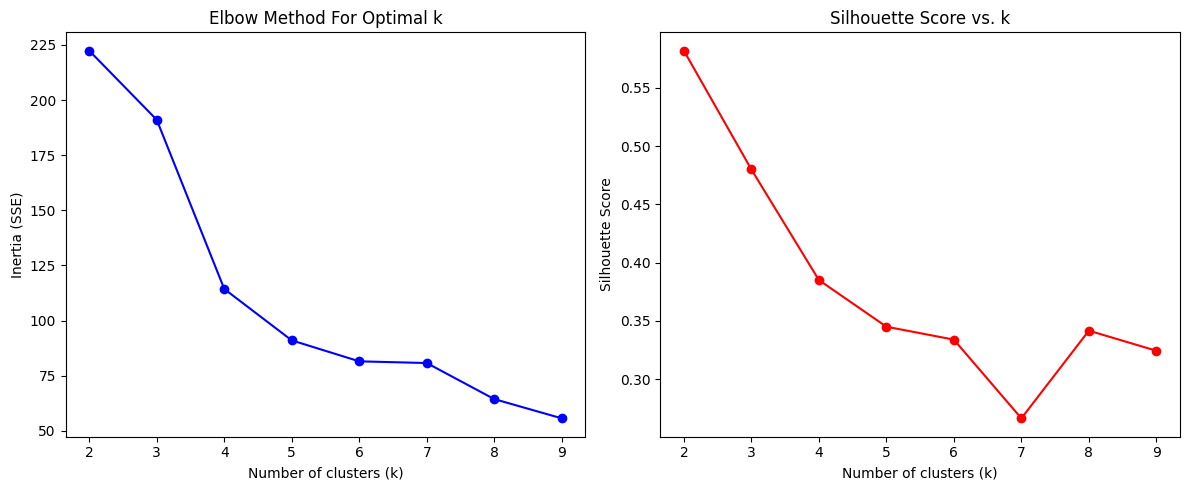

In [ ]:
inertia = []
silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # Sum of squared distances
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow chart
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method For Optimal k')

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')

plt.tight_layout()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)


In summary, this cell applies Fuzzy C-Means to the scaled Iris data, calculates the fuzzy membership degrees, and then converts these degrees into definite cluster labels for each data point.

In [ ]:
X_T = X_scaled.T  # FCM needs transposed input
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    X_T, c=3, m=2, error=0.005, maxiter=1000, init=None)

# Convert fuzzy memberships to crisp labels
fuzzy_labels = np.argmax(u, axis=0)


In [ ]:
from sklearn.metrics import confusion_matrix

print("Adjusted Rand Index (KMeans):", adjusted_rand_score(y_true, kmeans_labels))
print("Adjusted Rand Index (Fuzzy C-Means):", adjusted_rand_score(y_true, fuzzy_labels))


Adjusted Rand Index (KMeans): 0.48023040730947325
Adjusted Rand Index (Fuzzy C-Means): 0.6303393343888227


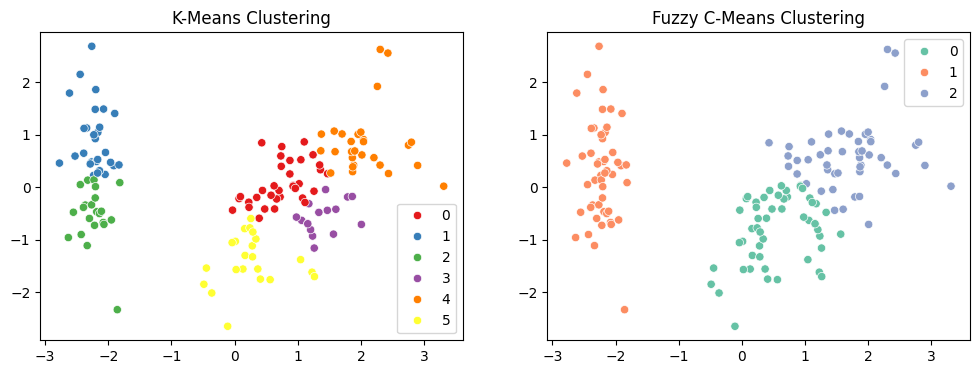

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_labels, palette='Set1')
plt.title('K-Means Clustering')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=fuzzy_labels, palette='Set2')
plt.title('Fuzzy C-Means Clustering')

plt.show()


This plot shows how the objective function decreases as the Fuzzy C-Means algorithm iterates. A decreasing curve indicates that the algorithm is converging towards a local minimum, and the plot helps visualize this convergence process.



In [ ]:
from sklearn.utils import shuffle

subset_sizes = np.linspace(0.2, 1.0, 5)  # 20%, 40%, ..., 100%
kmeans_inertia = []
kmeans_silhouette = []
fcm_fpc = []

X_shuffled, y_shuffled = shuffle(X_scaled, y_true, random_state=42)

for frac in subset_sizes:
    n_samples = int(len(X_shuffled) * frac)
    X_subset = X_shuffled[:n_samples]

    # --- KMeans ---
    kmeans = KMeans(n_clusters=3, random_state=42)
    labels_km = kmeans.fit_predict(X_subset)
    kmeans_inertia.append(kmeans.inertia_)
    if len(np.unique(labels_km)) > 1:
        kmeans_silhouette.append(silhouette_score(X_subset, labels_km))
    else:
        kmeans_silhouette.append(np.nan)

    # --- Fuzzy C-Means ---
    X_subset_T = X_subset.T
    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
        X_subset_T, c=3, m=2, error=0.005, maxiter=1000, init=None)
    fcm_fpc.append(fpc)


These learning curves provide insights into how the clustering results (measured by inertia for K-Means and FPC for Fuzzy C-Means) are influenced by the size of the dataset.

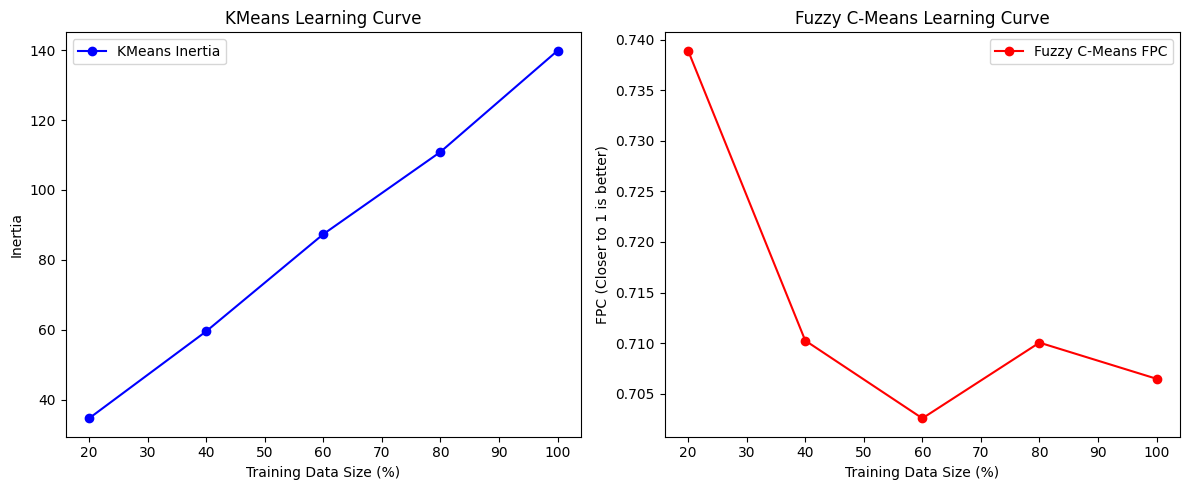

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(subset_sizes * 100, kmeans_inertia, 'bo-', label='KMeans Inertia')
plt.xlabel('Training Data Size (%)')
plt.ylabel('Inertia')
plt.title('KMeans Learning Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(subset_sizes * 100, fcm_fpc, 'ro-', label='Fuzzy C-Means FPC')
plt.xlabel('Training Data Size (%)')
plt.ylabel('FPC (Closer to 1 is better)')
plt.title('Fuzzy C-Means Learning Curve')
plt.legend()

plt.tight_layout()
plt.show()


C-means & K-means Loss Function visualization

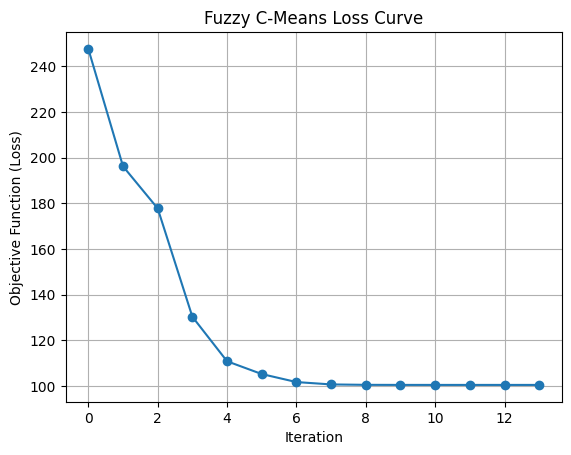

In [ ]:
X_T = X_scaled.T

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_T, c=3, m=2, error=0.005, maxiter=100, init=None)

# Plot loss (objective function value) over iterations
plt.plot(jm, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective Function (Loss)')
plt.title('Fuzzy C-Means Loss Curve')
plt.grid(True)
plt.show()


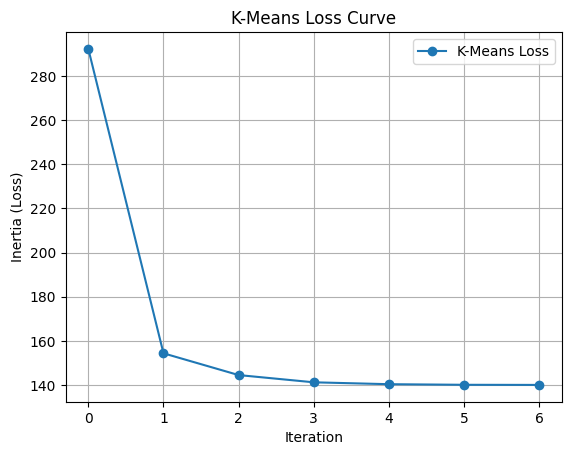

In [ ]:
def kmeans_loss_curve(X, k, max_iter=20):
    n_samples, n_features = X.shape
    rng = np.random.RandomState(42)
    centers = X[rng.choice(n_samples, k, replace=False)]
    losses = []

    for _ in range(max_iter):
        # Assign each sample to the nearest center
        distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
        labels = np.argmin(distances, axis=1)

        # Compute inertia (loss)
        loss = np.sum((X - centers[labels])**2)
        losses.append(loss)

        # Update centers
        new_centers = np.array([X[labels == i].mean(axis=0) if len(X[labels == i]) > 0 else centers[i]
                                for i in range(k)])
        if np.allclose(centers, new_centers):
            break
        centers = new_centers

    return losses

# Run and plot
kmeans_losses = kmeans_loss_curve(X_scaled, k=3)
plt.plot(kmeans_losses, marker='o', label='K-Means Loss')
plt.xlabel('Iteration')
plt.ylabel('Inertia (Loss)')
plt.title('K-Means Loss Curve')
plt.grid(True)
plt.legend()
plt.show()


## 🔍 Recommended Projects: Dive Deeper into Clustering & Fuzzy Logic

If you found this comparison between **Fuzzy C-Means and K-Means** insightful, here are more advanced and related projects to explore. These are perfect for deepening your understanding of clustering in real-world, uncertain environments:

---

### 🌀 1. Fuzzy C-Means vs. DBSCAN  
**Goal:** Compare how fuzzy boundaries (Fuzzy C-Means) handle overlap vs. how DBSCAN handles density and outliers.  
- Use Case: Noisy or irregular data shapes  
- Bonus: Explore hybrid approaches

---

### 📉 2. Fuzzy Clustering + PCA / t-SNE / UMAP  
**Goal:** Visualize fuzzy membership degrees in reduced dimensions.  
- Show points with mixed memberships using color gradients  
- Toolset: `PCA`, `t-SNE`, `UMAP`, `plotly`, or `seaborn`

---

### ⏱️ 3. Real-Time Clustering with Fuzzy Logic  
**Goal:** Apply fuzzy clustering on streaming or time-windowed data  
- Simulate real-time changes in data  
- Tool: `River ML`, or create a sliding window simulation

---

### 📊 4. Evaluation Metrics: Hard vs. Fuzzy Clustering  
**Goal:** Quantitatively assess performance differences using:  
- **Silhouette Score** (for hard clustering)  
- **Partition Coefficient**, **Fuzzy Entropy** (for fuzzy clustering)  
- Visualize results side by side

---

### 🧠 5. Fuzzy Rule-Based System (Post-Clustering Decision Logic)  
**Goal:** Build an expert-like decision system after fuzzy clustering  
- Example:  
  `"If Membership in Cluster A > 0.6 and Score > Threshold → Trigger Alert"`  
- Tool: `skfuzzy.control` system (rule-based engine)

---

✅ All of these can be implemented using:
- `scikit-learn`  
- `scikit-fuzzy`  
- `matplotlib`, `seaborn`, or `plotly`  
- `pandas`, `numpy`

---

👉 Want me to open-source these next?  
Leave a comment or fork this notebook and try them yourself!

